In [1]:
import numpy as np
from shapely.geometry import Point
from shapely.ops import cascaded_union

!pip install rtree
!pip install geopandas
import rtree
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 994 kB 10.1 MB/s 
     |████████████████████████████████| 994 kB 9.3 MB/s 
     |████████████████████████████████| 15.4 MB 36 kB/s 
     |████████████████████████████████| 6.6 MB 40.0 MB/s 


In [2]:
import folium, folium.plugins
from folium import plugins, FeatureGroup, LayerControl, Map
from folium.plugins import HeatMap, MarkerCluster, FeatureGroupSubGroup

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Preparation

## 1.1 Load Maps of Wards

http://bklyn-genealogy-info.stevemorse.org/Ward/

In [ ]:
wards = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/nyc-wards.geojson')

In [ ]:
wards_1900 = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/enumeration-districts.geojson')

In [ ]:
location=[40.767937,-73.982155]
tiles="cartodbpositron"

map = folium.Map(location=location, tiles=None, zoom_start=12)
base_map = FeatureGroup(name='Base Map', overlay=True, control=False)
folium.TileLayer(tiles=tiles).add_to(base_map)
base_map.add_to(map)

for name, group in wards.groupby(['validSince', 'validUntil']):
  layer = FeatureGroup(name=name, overlay=False)
  temp = wards[(wards['validSince']==name[0])&(wards['validUntil']==name[1])]
  folium.Choropleth(geo_data=temp, fill_color='lightblue',
                    fill_opacity=0.7, highlight=True,
                    line_opacity=0.2,).add_to(layer)
  layer.add_to(map)

folium.LayerControl(collapsed=False).add_to(map)
map

In [ ]:
location=[40.767937,-73.982155]
tiles="cartodbpositron"

map = folium.Map(location=location, tiles=tiles, zoom_start=12)
folium.Choropleth(geo_data=wards_1900, fill_color='lightblue',
                    fill_opacity=0.7,
                    line_opacity=0.2,).add_to(map)
map

**Problems：**
- Enumeration districts map is valid in 1900s. But it doesn't cover the complete area of Manhattan. And the districts are too small/meticulous to be used in a choropleth map.
- Wards maps are only valid in 1800s. The most suitbale map is valid from 1850 to 1895, which matches with our 1880 census dataset. However, the rest datasets (1900, 1910, 1920, 1930 and 1940) do not match this ward map in respect to time.

**For the following choropleth maps, we will use the ward map which is valid from 1853 to 1895.**

In [ ]:
wards2 = wards[(wards['validSince']==1853)&(wards['validUntil']==1895)]

## 1.2 Load Raw Data

In [4]:
wards = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/nyc-wards.geojson')
wards2 = wards[(wards['validSince']==1853)&(wards['validUntil']==1895)]

In [5]:
df_1940 = pd.read_csv('/content/drive/MyDrive/geocoded_clean_data/geocoded_census_1940.csv')
df_1930 = pd.read_csv('/content/drive/MyDrive/geocoded_clean_data/geocoded_census_1930.csv')
df_1920 = pd.read_csv('/content/drive/MyDrive/geocoded_clean_data/geocoded_census_1920.csv')
df_1910 = pd.read_csv('/content/drive/MyDrive/geocoded_clean_data/geocoded_census_1910.csv')
df_1900 = pd.read_csv('/content/drive/MyDrive/geocoded_clean_data/geocoded_census_1900.csv')
df_1880 = pd.read_csv('/content/drive/MyDrive/geocoded_clean_data/geocoded_census_1880.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,6,26,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,7,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr

In [6]:
def df_cleaner(df, year=None):
    """This function cleans geo-coded data frames by separating the field "Coordinates" into two fields: "Latitude" and "longitude"
    """
    df_clean = df.dropna(axis=0, subset = ['Coordinates'])
    df_clean['Latitude'] = [eval(i)[0] for i in df_clean['Coordinates']]
    df_clean['Longitude'] = [eval(i)[1] for i in df_clean['Coordinates']]
    print()
    print('Number of available data in', str(year)+':', df_clean.shape)
    print('Proportion of available data in', str(year)+':', round(df_clean.shape[0]/df.shape[0], 3))
    print()
    return df_clean

In [7]:
df_1940_clean = df_cleaner(df_1940, 1940)
df_1940_geo = df_1940_clean[['RecordId', 'Latitude', 'Longitude']]
del df_1940
df_1930_clean = df_cleaner(df_1930, 1930)
df_1930_geo = df_1930_clean[['RecordId', 'Latitude', 'Longitude']]
del df_1930
df_1920_clean = df_cleaner(df_1920, 1920)
df_1920_geo = df_1920_clean[['RecordId', 'Latitude', 'Longitude']]
del df_1920
df_1910_clean = df_cleaner(df_1910, 1910)
df_1910_geo = df_1910_clean[['RecordId', 'Latitude', 'Longitude']]
del df_1910
df_1900_clean = df_cleaner(df_1900, 1900)
df_1900_geo = df_1900_clean[['RecordId', 'Latitude', 'Longitude']]
del df_1900
df_1880_clean = df_cleaner(df_1880, 1880)
df_1880_geo = df_1880_clean[['RecordId', 'Latitude', 'Longitude']]
del df_1880

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



Number of available data in 1940: (433563, 34)
Proportion of available data in 1940: 0.237



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



Number of available data in 1930: (1091114, 38)
Proportion of available data in 1930: 0.592



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



Number of available data in 1920: (415682, 36)
Proportion of available data in 1920: 0.185



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



Number of available data in 1910: (496766, 37)
Proportion of available data in 1910: 0.181



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



Number of available data in 1900: (620047, 37)
Proportion of available data in 1900: 0.309



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """



Number of available data in 1880: (686736, 31)
Proportion of available data in 1880: 0.577



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 1.3 Assign wards

In [8]:
# ~ 8 seconds
def assign_ward(df, ward):
  '''This function assigns each dots in the dataset to the ward it belongs to. 
  '''
  # 1: Group the data by same addresses
  df_temp = df.groupby(['Latitude', 'Longitude'])[[]].count().reset_index()

  # 2: Form a geometry column of each data point
  geometry = [Point(xy) for xy in zip(df_temp['Longitude'], df_temp['Latitude'])]
  crs = {'init':'epsg:4326'}
  geo_df_temp = gpd.GeoDataFrame(df_temp, crs=crs, geometry=geometry)

  # 3: Spatial join of points and wards
  joined = gpd.sjoin(geo_df_temp, ward, how="left")

  df_new = pd.merge(df, joined[['Latitude', 'Longitude', 'index_right', 'id', 'name']], how='left', on=['Latitude', 'Longitude'])
  return df_new

In [9]:
df_1940_geo = assign_ward(df_1940_geo, wards2)
df_1930_geo = assign_ward(df_1930_geo, wards2)
df_1920_geo = assign_ward(df_1920_geo, wards2)
df_1910_geo = assign_ward(df_1910_geo, wards2)
df_1900_geo = assign_ward(df_1900_geo, wards2)
df_1880_geo = assign_ward(df_1880_geo, wards2)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in

# 2 Mapping

## 2.1 Colorbar Setting

In [10]:
df_1940_choro = df_1940_geo.groupby('id')[['RecordId']].count().reset_index()
wards_1940 = pd.merge(wards2, df_1940_choro, on='id', how='left')

In [11]:
wards_1940['RecordId_log'] = [np.log(i) for i in wards_1940['RecordId']]

**Why take the log of absolute number of residents in each ward?**

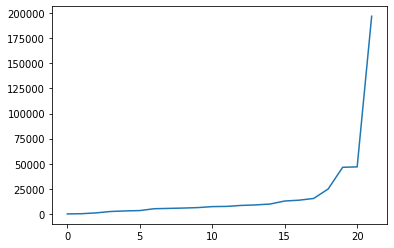

In [ ]:
wards_1940['RecordId'].sort_values().reset_index()['RecordId'].plot()

In [ ]:
# create the stepped colorbar
import branca
import branca.colormap as cm
colormap = cm.linear.YlGnBu_09.to_step(data=wards_1940['RecordId'], method='quant', quantiles=[0, 0.1,0.25, 0.5, 0.75, 0.9,1])
colormap

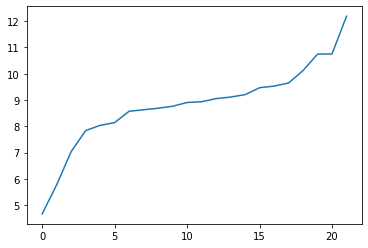

In [ ]:
wards_1940['RecordId_log'].sort_values().reset_index()['RecordId_log'].plot()

In [ ]:
colormap = cm.linear.YlGnBu_09.to_step(data=wards_1940['RecordId_log'], method='quant', quantiles=[0, 0.1,0.25, 0.5, 0.75, 0.9,1])
colormap

## 2.2 Map Functions
### 2.2.1 Choropleth Map of Population

In [92]:
def geo_choropleth(ward, df, on='id', value='RecordId', location=[40.767937,-73.982155], tiles="cartodbpositron", name=None):
  new_ward = pd.merge(ward, df.groupby(on)[[value]].count().reset_index(), on=on, how='left')
  new_ward.loc[new_ward[value].isnull(), value] = 0.01
  new_ward[value+'_log'] = [np.log(i) for i in new_ward[value]]
  new_ward[value+'_Proportion'] = round(100*new_ward[value]/df.shape[0], 2)
  
  import branca
  import branca.colormap as cm
  colormap = cm.linear.YlGnBu_09.to_step(data=new_ward[value+'_log'], method='quant', quantiles=[0, 0.1, 0.25, 0.5, 0.75, 0.9,1])
  colormap.caption = "Log of Number of Residents in Each Ward"

  map = folium.Map(location=location, zoom_start=12, tiles=None)
  base_map = FeatureGroup(name='Base Map', overlay=True, control=False)
  folium.TileLayer(tiles=tiles).add_to(base_map)
  base_map.add_to(map)

  style_function = lambda x: {"weight":0.5, 
                            'color':'black',
                            'fillColor':colormap(x['properties'][value+'_log']), 
                            'fillOpacity':0.75}
  highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
  
  folium.GeoJson(new_ward,
    style_function=style_function,
    control=True, overlay=False, name='Choropleth',
    highlight_function=highlight_function,
    tooltip=folium.features.GeoJsonTooltip(fields=[on, value, value+'_Proportion'],
    aliases=['Ward:','Population:', "Proportion of population (%):"],
    style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
    sticky=True)).add_to(map)
  colormap.add_to(map)

  if name is not None:
    base_map.save(r'choropleth_'+name+'.html')
    print('Map saved.')

  folium.LayerControl(collapsed=False).add_to(map)
  return map


In [38]:
geo_choropleth(wards2, df_1940_geo)

### 2.2.2 Compare Choropleth Maps

In [91]:
def geo_choropleth_compare(ward, grid_of_df, on='id', value='RecordId', location=[40.767937,-73.982155], tiles="cartodbpositron", name=None):
  import branca
  import branca.colormap as cm

  map = folium.Map(location=location, zoom_start=12, tiles=None)
  base_map = FeatureGroup(name='Base Map', overlay=True, control=False)
  folium.TileLayer(tiles=tiles).add_to(base_map)
  base_map.add_to(map)

  for k, df in grid_of_df.items():
    print(k)
    layer = FeatureGroup(name=k, overlay=False)
    new_ward = pd.merge(ward, df.groupby(on)[[value]].count().reset_index(), on=on, how='left')
    new_ward.loc[new_ward[value].isnull(), value] = 0.01
    new_ward[value+'_log'] = [np.log(i) for i in new_ward[value]]
    new_ward[value+'_Proportion'] = round(100*new_ward[value]/df.shape[0], 2)
    colormap = cm.linear.YlGnBu_09.to_step(data=new_ward[value+'_log'], method='quant', quantiles=[0, 0.1, 0.25, 0.5, 0.75, 0.9,1])
    colormap.caption = "Log of Number of Residents in Each Ward"
    style_function = lambda x: {"weight":0.5, 
                            'color':'black',
                            'fillColor':colormap(x['properties'][value+'_log']), 
                            'fillOpacity':0.75}
    highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
    folium.GeoJson(new_ward,
        style_function=style_function,
        control=False,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(fields=['id','RecordId', value+'_Proportion'],
        aliases=['Ward:','Population:', "Proportion of population (%):"],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
        sticky=True)).add_to(layer)
    # colormap.add_to(layer)
    layer.add_to(map)

  folium.LayerControl(collapsed=False).add_to(map)
  return map


In [14]:
grid_of_df = {'1940_population': df_1940_geo, '1930_population': df_1930_geo, '1920_population': df_1920_geo, 
              '1910_population': df_1910_geo, '1900_population': df_1900_geo, '1880_population': df_1880_geo}

In [32]:
geo_choropleth_compare(wards2, grid_of_df)

### 2.2.3 Compare Choropleth Map of Different Values in a Field

In [68]:
def geo_choropleth_compare2(ward, df, field, on='id', value='RecordId', location=[40.767937, -73.982155], tiles='cartodbpositron', name=None):
  df.dropna(axis=0, subset=[field], inplace=True)
  d = {}
  for v in df[field].unique().tolist()[:10]:
    d[v] = df[df[field]==v]
  return geo_choropleth_compare(ward, d, on, value, location, tiles, name)

In [54]:
df, field = df_1930_all, 'Race'
d = {}
for v in df[field].unique().tolist()[:10]:
  d[v] = df[df[field]==v]

In [89]:
new = pd.merge(wards2, d['Chinese'].groupby('id')[['RecordId']].count().reset_index(), on='id', how='left')
new.loc[new['RecordId'].isnull(), 'RecordId'] = 0.01

In [94]:
[np.log(i) for i in new['RecordId']]

[4.060443010546419,
 -4.605170185988091,
 1.3862943611198906,
 2.1972245773362196,
 -4.605170185988091,
 8.017966703493599,
 5.056245805348308,
 1.0986122886681098,
 2.772588722239781,
 4.77912349311153,
 6.54965074223381,
 2.5649493574615367,
 1.3862943611198906,
 2.995732273553991,
 2.302585092994046,
 4.219507705176107,
 6.169610732491456,
 4.7535901911063645,
 3.7612001156935624,
 2.995732273553991,
 3.8501476017100584,
 5.081404364984463]

# Appendix.

In [ ]:
gpd_choro = pd.merge(wards, df_1940_choro, left_on='name', right_on='Region')

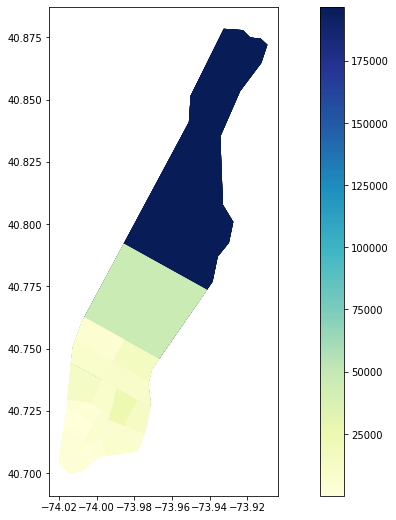

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))
gpd_choro.plot(ax=ax, column='RecordId', cmap='YlGnBu', k=3, legend=True)

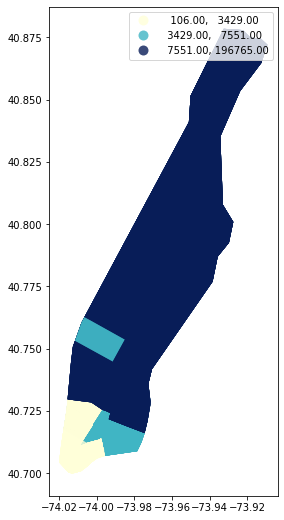

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))
gpd_choro.plot(ax=ax, column='RecordId', cmap='YlGnBu', scheme='quantiles', k=3,alpha=0.8, legend=True)

In [ ]:
!pip install mapclassify